In [1]:
from torch_geometric.datasets import CitationFull
import pandas as pd
from kgnas.KGNAS import KGNAS
from nas_bench_graph import Arch, light_read
import numpy as np
import scipy.stats as stats

# Initialize the KGNAS class
# The numerical_weight is the weight of the numerical features in evaluating the dataset similarities, by default it is 0.5. The categorical weight is (1 - numerical_weight).
kgnas = KGNAS()

In [2]:
kgnas.save_knowledge_graph()

num macro types 4
num micro types 15
num entities 211739
num relation types 14
num relations 2540064


In [6]:
import json

with open("./KG/KGNAS_knowledge_graph_entities.json", 'r') as f:
    entities = json.load(f)

dataset_entities = [entity for entity in entities if entity['macro_type'] == 'dataset' and entity['micro_type'] == 'dataset']
dataset_entities[0]

model_entities = [entity for entity in entities if entity['macro_type'] == 'model' and entity['micro_type'] == 'model']
model_entities[0]

with open("./KG/KGNAS_knowledge_graph_relations.json", 'r') as f:
    relations = json.load(f)

performance_relations = [relation for relation in relations if relation['macro_type'] == 'model' and relation['relation'] == 'has_performance']
performance_relations[0]

{'source_entity': 0,
 'target_entity': 17,
 'macro_type': 'model',
 'relation': 'has_performance',
 'property': {'valid_perf': 0.7733333333333334,
  'perf': 0.797,
  'latency': 0.005922238032023112,
  'para': 1.736711,
  'task': 'Node Classification'},
 'id': 2328395}

In [2]:
def eval_init_recommendation(dataset_name, top_k_dataset, top_k_model, sim_metric, score_metric, sort_by='score'):
    init_df = kgnas.recommend_model(dataset_name, top_k_dataset=top_k_dataset, top_k_model=top_k_model, sim_metric=sim_metric, score_metric=score_metric, include_target_dataset=True)

    candidate_df = init_df[init_df['dataset'] != dataset_name]
    source_df = init_df[init_df['dataset'] == dataset_name]

    best_model = candidate_df.sort_values(by=sort_by, ascending=False).iloc[0]
    # print(best_model)
    
    struct_list = [int(i) for i in best_model['has_struct_topology'][1:-1].split(',')]
    layer_list = [best_model[f'has_struct_{i}'] for i in range(1, 5)]
    # print(struct_list, layer_list)
    bench = light_read(dataset_name)

    arch = Arch(struct_list, layer_list).valid_hash()

    if arch not in bench.keys():
        for model in candidate_df.iterrows():
            struct_list = [int(i) for i in model[1]['has_struct_topology'][1:-1].split(',')]
            layer_list = [model[1][f'has_struct_{i}'] for i in range(1, 5)]
            arch = Arch(struct_list, layer_list).valid_hash()
            if arch in bench.keys():
                break
        # return None, None

    info = bench[Arch(struct_list, layer_list).valid_hash()]
    
    return info['perf'], source_df['perf'].head()

In [3]:
def collect_perf(sim_metric, score_metric, sort_by):
    data_names = ['cora', 'citeseer', 'pubmed', 'cs', 'physics', 'photo', 'computers', 'arxiv']

    perf_dict = {name: 0 for name in data_names}
    for name in data_names:
        retrieved_perf = eval_init_recommendation(name, 4, 40, sim_metric, score_metric, sort_by)
        perf_dict[name] = str(float(retrieved_perf[0])*100)[:5]
    print(('\t').join(v for v in perf_dict.values()))
    return perf_dict

In [9]:
kgnas.standardize = False
kgnas.activation = 'power'
kgnas.power = -2
kgnas.upper_bound = 0.8
kgnas.process_method = 'outlier'
kgnas.bound_frac = 0.5
kgnas.set_num_weight(1.0)

collect_perf('gower', 'avg', 'score')

80.36	69.2	76.53	89.32	90.34	90.37	76.61	70.38


{'cora': '80.36',
 'citeseer': '69.2',
 'pubmed': '76.53',
 'cs': '89.32',
 'physics': '90.34',
 'photo': '90.37',
 'computers': '76.61',
 'arxiv': '70.38'}

In [9]:
for sim_metric in ['l1', 'l2', 'cosine', 'gower']:
    # for score_metric in ['avg', 'max']:
    for sort_by in ['score', 'perf']:
        if sort_by == 'score':
            for score_metric in ['avg', 'mult']:
                perf_dict = collect_perf(sim_metric, score_metric, sort_by)
                template = raw_data_df.iloc[0].copy(deep=True)

                template['Type'] = 'KG-NAS'
                template['Model'] = f'{sim_metric}-{sort_by}-{score_metric}'

                vals = list(collect_perf(sim_metric, score_metric, sort_by).values())

                for i in range(2, 10):
                    template[raw_data_df.columns[i]] = vals[i-2]
                    
                raw_data_df = raw_data_df._append(template, ignore_index=True)
        else:
            perf_dict = collect_perf(sim_metric, 'avg', sort_by)
            template = raw_data_df.iloc[0].copy(deep=True)

            template['Type'] = 'KG-NAS'
            template['Model'] = f'{sim_metric}-{sort_by}'

            vals = list(collect_perf(sim_metric, 'avg', sort_by).values())

            for i in range(2, 10):
                template[raw_data_df.columns[i]] = vals[i-2]
                
            raw_data_df = raw_data_df._append(template, ignore_index=True)

In [5]:
template = raw_data_df.iloc[0].copy(deep=True)

template['Type'] = 'KG-NAS'
template['Model'] = 'score-avg-l2'

vals = list(collect_perf('l2', 'avg', 'score').values())

for i in range(2, 10):
    template[raw_data_df.columns[i]] = vals[i-2]
    
raw_data_df = raw_data_df._append(template, ignore_index=True)

In [5]:
def case_study_init_recommendation(dataset_name):
    print(kgnas.get_similar_dataset(dataset_name, top_k=5, sim_metric='gower'))
    perf, related_perf = eval_init_recommendation(dataset_name, 4, 10, 'gower', 'avg', sort_by='score')
    print(perf)
    print(related_perf)

In [26]:
kgnas.get_similar_dataset('cs', top_k=5, sim_metric='gower')

,dataset,dataset_similarity
3,cs,1.000000
4,physics,0.897007
2,pubmed,0.841634
1,citeseer,0.828561
7,arxiv,0.797954


In [9]:
data_description_df = pd.DataFrame({
    'Type': ['Homogeneous', 'Homogeneous', 'Homogeneous', 'Homogeneous', 'Homogeneous', 'Homogeneous', 'Homogeneous', 'Homogeneous', 'Homogeneous'], 
    'node_feature': [1433, 3703, 500, 6805, 8415, 745, 767, 128, 0], 
    'assortativity': [-0.06587087427227857, 0.048378078374214546, -0.04364031570334561, 0.11260854329931977, 0.2010313810362111, -0.04494270527930541, -0.056487705164197634, -0.04311895177607261, 0.35520272226167543], 
    'FeatureType': ['Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Node', 'Edge'], 
    'local_average_clustering_coefficient': [None, None, None, None, None, None, None, None, 0.6573941635441265], 
    'average_clustering_coefficient': [0.24067329850193728, 0.14147102442629086, 0.060175209437523615, 0.34252338196985804, 0.3776229390845259, 0.4039792743937545, 0.34412638745332397, 0.22612914062470202, None], 
    'average_degree_centrality': [0.0014399999126942077, 0.0008227297529768376, 0.00022803908825811387, 0.0004873474441645473, 0.0004168365381774087, 0.004070112116838717, 0.0026002762758509414, 8.074789913670332e-05, 0.004504521754591681], 'local_average_betweenness_centrality': [0.0, 0.06637426900584795, 0.04038367546432063, 0.034573103206115105, 0.01289624003515159, 0.002738664262816096, 0.003674253329531406, 0.020211893569974666, 0.0051445249418492715], 
    'edge_count': [5278, 4552, 44324, 81894, 247962, 119081, 245861, 1157799, 39561252], 
    'NumClasses': [7, 6, 3, 15, 5, 8, 10, 40, 112], 
    'density': [0.0014399999126942077, 0.0008227297529768376, 0.00022803908825811382, 0.00048734744416454727, 0.0004168365381774087, 0.004070112116838717, 0.0026002762758509414, 8.074789913670332e-05, 0.004504521754591681], 'average_eigenvector_centrality': [0.0047865456098027765, 0.0033854307488708703, 0.0014101036104415428, 0.0023585311444032655, 0.0016277767776128051, 0.004240506438932563, 0.0033683404991575005, 0.0007299364762486809, 0.0005329522847746617], 
    'Task': ['Node Classification', 'Node Classification', 'Node Classification', 'Node Classification', 'Node Classification', 'Node Classification', 'Node Classification', 'Node Classification', 'Node Classification'], 
    'local_average_closeness_centrality': [1.0, 0.4697435587367421, 0.4524748732421055, 0.4244744169883969, 0.30603317639876243, 0.3746486414543327, 0.3940379176382557, 0.3338630446056274, 0.5694732422316185], 
    'node_count': [2708, 3327, 19717, 18333, 34493, 7650, 13752, 169343, 132534], 
    'average_degree': [3.8980797636632203, 2.7363991584009617, 4.496018664096972, 8.93405334642448, 14.37752587481518, 31.132287581699348, 35.7563990692263, 13.674010735607613, 596.9977817012993], 
    'LabelType': ['Single', 'Single', 'Single', 'Single', 'Single', 'Single', 'Single', 'Single', 'Multiple'], 
    'connected_components': [78, 438, 1, 1, 1, 136, 314, 1, 1], 
    'local_graph_diameter': [1.0, 4.0, 3.0, 4.0, 4.0, 4.0, 4.0, 4.0, 2.0], 
    'Metric': ['Accuracy', 'Accuracy', 'Accuracy', 'Accuracy', 'Accuracy', 'Accuracy', 'Accuracy', 'Accuracy', 'ROC-AUC'], 
    'edge_feature': [0, 0, 0, 0, 0, 0, 0, 0, 8], 
    'Dataset': ['cora', 'citeseer', 'pubmed', 'cs', 'physics', 'photo', 'computers', 'arxiv', 'proteins'],
    'local_average_shortest_path_length': [1.0, 2.1947368421052635, 2.251893939393939, 2.4174972314507195, 3.2955307262569833, 2.69797184294598, 2.5689061717099104, 3.0616131441374166, 1.7665342163355409],
    'EdgeSemantic': ['Citation', 'Citation', 'Citation', 'Coauthor', 'Coauthor', 'Coappearance', 'Coappearance', 'Citation', 'Biological Interaction'], 
    'Domain': ['Computer Science', 'Computer Science', 'Medical', 'Computer Science', 'Physics', 'Business', 'Business', 'Computer Science', 'Medical'], 
}
)

data_description_df.set_index('Dataset', inplace=True)

In [5]:
def recommend_with_all(dataset_name, top_k_model, sim_metric, score_metric, sort_by='score'):
    init_df = kgnas.recommend_model(dataset_name, top_k_dataset=9, top_k_model=top_k_model, sim_metric=sim_metric, score_metric=score_metric, include_target_dataset=True)

    candidate_df = init_df[init_df['dataset'] != dataset_name]
    source_df = init_df[init_df['dataset'] == dataset_name]

    info_dict = {data: {'perf': [], 'rank': []} for data in ['cora', 'citeseer', 'pubmed', 'cs', 'physics', 'photo', 'computers', 'arxiv', 'proteins']}
    for dataset in ['cora', 'citeseer', 'pubmed', 'cs', 'physics', 'photo', 'computers', 'arxiv', 'proteins']:
        for k in range(top_k_model):
            if dataset != dataset_name:
                best_model = candidate_df[candidate_df['dataset'] == dataset].sort_values(by=sort_by, ascending=False).iloc[k]

                struct_list = [int(i) for i in best_model['has_struct_topology'][1:-1].split(',')]
                layer_list = [best_model[f'has_struct_{i}'] for i in range(1, 5)]
                # print(struct_list, layer_list)
                bench = light_read(dataset_name)

                arch = Arch(struct_list, layer_list).valid_hash()

                if arch not in bench.keys():
                    for model in candidate_df.iterrows():
                        struct_list = [int(i) for i in model[1]['has_struct_topology'][1:-1].split(',')]
                        layer_list = [model[1][f'has_struct_{i}'] for i in range(1, 5)]
                        arch = Arch(struct_list, layer_list).valid_hash()
                        if arch in bench.keys():
                            break
                # return None, None

                info_dict[dataset]['perf'].append(bench[Arch(struct_list, layer_list).valid_hash()]['perf'])
                # info = bench[Arch(struct_list, layer_list).valid_hash()]
            else:
                info_dict[dataset]['perf'].append(source_df['perf'].iloc[k])
    
    # info_dict = pd.DataFrame(info_dict, index=[0])
    similarity_dict = kgnas.get_similar_dataset(dataset_name, top_k=9, sim_metric=sim_metric).copy(deep=True)
    similarity_dict.set_index('dataset', inplace=True)
    for name in similarity_dict.index:
        perf_arr = np.array(info_dict[name]['perf'])
        similarity_dict.loc[name, 'perf'] = perf_arr.mean()
        similarity_dict.loc[name, 'perf_std'] = perf_arr.std()
        original_rank = np.array(range(top_k_model))

        sorted_indices = np.argsort(perf_arr)
        result_rank = np.empty_like(sorted_indices)
        result_rank[sorted_indices] = np.arange(len(perf_arr))
        result_rank = top_k_model - result_rank - 1

        kendall_tau, _ = stats.kendalltau(original_rank, result_rank)

        similarity_dict.loc[name, 'kendall_tau'] = kendall_tau
        # print(name, info_dict[name])
    
    return similarity_dict

def calculate_mrr(original, computed):
    rank = [original[i] + 1 for i, x in enumerate(computed)]
    mrr = np.mean([1.0/r for r in rank])
    return mrr

In [28]:
kgnas.standardize = False
kgnas.activation = 'power'
kgnas.power = -3
kgnas.upper_bound = 0.8
kgnas.process_method = 'outlier'
kgnas.bound_frac = 0.5
kgnas.set_num_weight(1.0)

sim_perf_df = recommend_with_all('physics', 1, 'gower', 'avg', sort_by='score')

sim_perf_df

,dataset_similarity,perf,perf_std,kendall_tau
dataset,,,,
physics,1.000000,0.930049,0.0,NaN
cs,0.960369,0.903416,0.0,NaN
arxiv,0.945154,0.918884,0.0,NaN
pubmed,0.935674,0.897342,0.0,NaN
computers,0.914975,0.899571,0.0,NaN
photo,0.912790,0.915652,0.0,NaN
citeseer,0.912443,0.902160,0.0,NaN
cora,0.901125,0.905304,0.0,NaN
proteins,0.887254,0.908974,0.0,NaN


In [23]:
data_description_df.loc[['physics', 'cs', 'arxiv', 'pubmed']].T

Dataset,physics,cs,arxiv,pubmed
Type,Homogeneous,Homogeneous,Homogeneous,Homogeneous
node_feature,8415,6805,128,500
assortativity,0.201031,0.112609,-0.043119,-0.04364
FeatureType,Node,Node,Node,Node
local_average_clustering_coefficient,NaN,NaN,NaN,NaN
average_clustering_coefficient,0.377623,0.342523,0.226129,0.060175
average_degree_centrality,0.000417,0.000487,0.000081,0.000228
local_average_betweenness_centrality,0.012896,0.034573,0.020212,0.040384
edge_count,247962,81894,1157799,44324
NumClasses,5,15,40,3


In [8]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

In [9]:
def plot_scatter_relation(df, x_key='dataset_similarity', y_key='perf'):
    # Preparing the data for linear regression
    # X = df['dataset_similarity'].values.reshape(-1, 1)
    # y = df['perf'].values

    # # Creating and fitting the model
    # model = LinearRegression()
    # model.fit(X, y)

    # # Predicting values
    # y_pred = model.predict(X)

    # r_squared = model.score(X, y)

    # slope = model.coef_[0]

    y_pred, r_squared, slope = get_LR_relation(df, x_key, y_key)

    # Scatter plot with linear regression line
    plt.figure(figsize=(10, 6))
    plt.scatter(df[x_key], df[y_key], marker='o', label='Data Points')

    # Plotting the linear regression line
    plt.plot(df[x_key], y_pred, color='red', label='Linear Regression Line')

    # Adding annotations for each point
    for i, txt in enumerate(df.index):
        plt.annotate(txt, (df.loc[txt, x_key], df.loc[txt, y_key]))

    # plt.text(5, 3, f'$R^2 = {r_squared:.2f}$', fontsize=12, color='red', transform=ax.transAxes)
    # plt.text(5, 3.5, f'Slope = {slope:.2f}', fontsize=12, color='blue')

    plt.title(f'Relationship between {x_key} and {y_key} with Linear Regression')
    plt.xlabel(x_key)
    plt.ylabel(y_key)
    plt.legend()
    plt.grid(True)

    plt.tight_layout()

    # Display the plot
    plt.show()

def get_LR_relation(df, x_key, y_key):
    X = df[x_key].values.reshape(-1, 1)
    y = df[y_key].values

    model = LinearRegression()
    model.fit(X, y)

    y_pred = model.predict(X)

    r_squared = model.score(X, y)
    slope = model.coef_[0]

    return y_pred, r_squared, slope

In [11]:
corr_df = {'dataset': [], 'slope': [], 'R_2': []}

for dataset in ['cora', 'citeseer', 'pubmed', 'cs', 'physics', 'photo', 'computers', 'arxiv', 'proteins']:
    sim_perf_df = recommend_with_all(dataset, 10, 'gower', 'avg', sort_by='score')
    y_pred, r_squared, slope = get_LR_relation(sim_perf_df, x_key='dataset_similarity', y_key='perf')
    corr_df['dataset'].append(dataset)
    corr_df['slope'].append(slope)
    corr_df['R_2'].append(r_squared)

corr_df = pd.DataFrame(corr_df)
corr_df

,dataset,slope,R_2
0,cora,0.256763,0.262000
1,citeseer,0.276551,0.230728
2,pubmed,0.122437,0.407595
3,cs,0.130939,0.315850
4,physics,0.051165,0.502667
5,photo,0.056485,0.265719
6,computers,0.050236,0.059716
7,arxiv,0.004645,0.006148
8,proteins,0.055351,0.933592


<Axes: title={'center': 'Slope of the Linear Regression Line for each Dataset Perf vs Similarity'}, xlabel='dataset'>

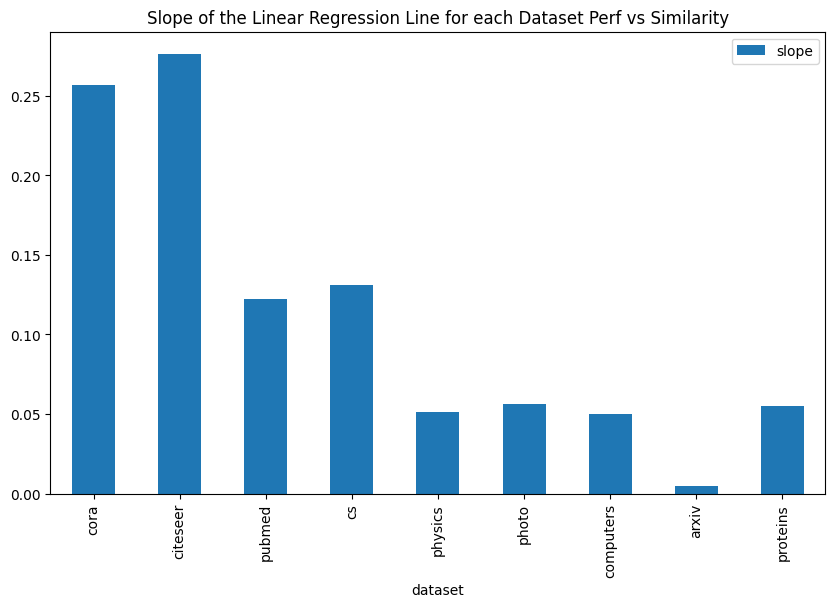

In [12]:
corr_df.plot(x='dataset', y='slope', kind='bar', figsize=(10, 6), title='Slope of the Linear Regression Line for each Dataset Perf vs Similarity')

<Axes: title={'center': 'R_2 of the Linear Regression Line for each Dataset Perf vs Similarity'}, xlabel='dataset'>

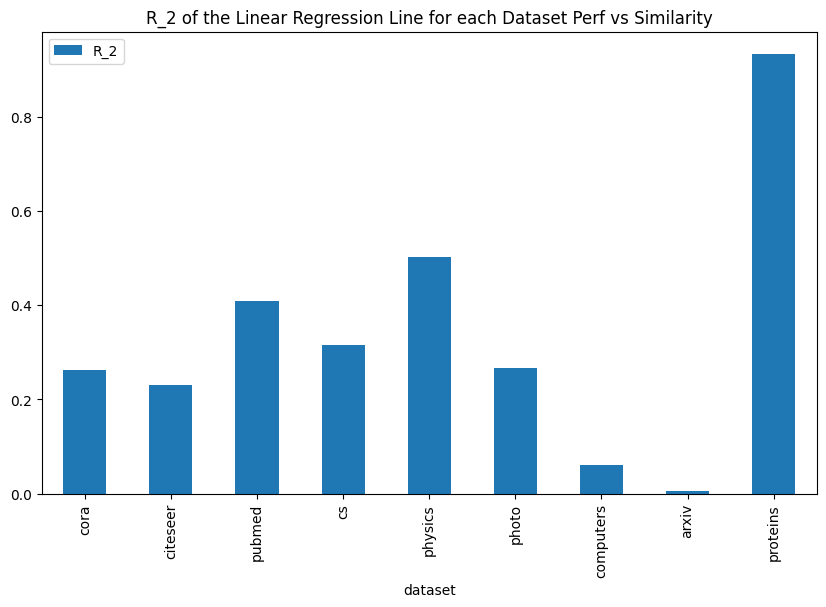

In [13]:
corr_df.plot(x='dataset', y='R_2', kind='bar', figsize=(10, 6), title='R_2 of the Linear Regression Line for each Dataset Perf vs Similarity')

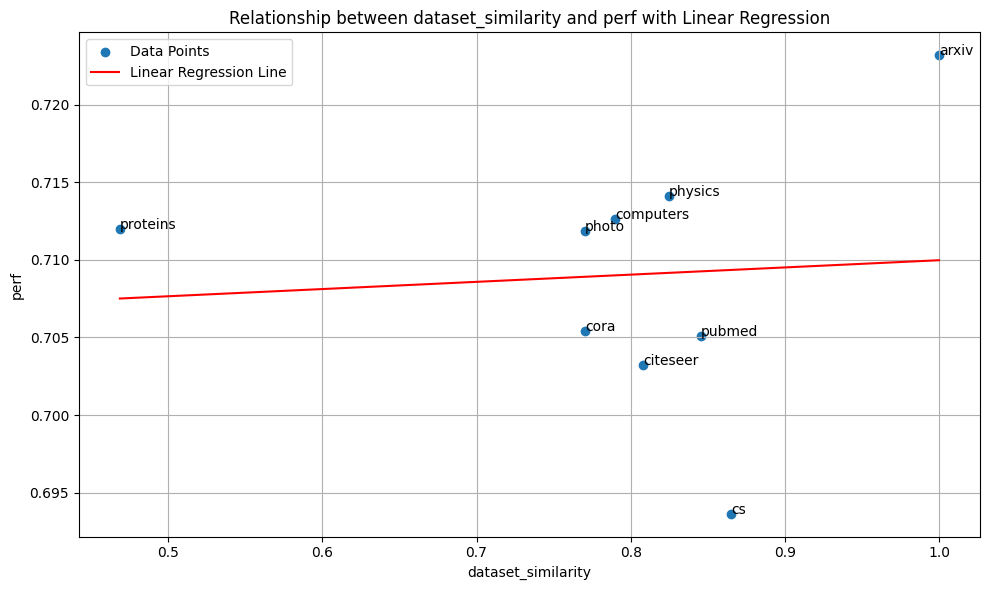

In [10]:
plot_scatter_relation(sim_perf_df)

In [10]:
target_dataset = 'physics'

kgnas.standardize = False
kgnas.activation = 'power'
kgnas.power = 1/3
kgnas.upper_bound = 0.8
kgnas.process_method = 'outlier'
kgnas.bound_frac = 0.4
kgnas.set_num_weight(1.0)

sim_perf_df = recommend_with_all(target_dataset, 1, 'gower', 'avg', sort_by='score')

print(sim_perf_df)

result_dict = {}
for dataset in ['cora', 'citeseer', 'pubmed', 'cs', 'physics', 'photo', 'computers', 'arxiv', 'proteins']:
    if dataset != target_dataset:
        result_dict[dataset] = kgnas.get_similarity_vector(target_dataset, dataset)
    
result_df = pd.DataFrame(result_dict).T
result_df.columns = kgnas.dataset_numerical_columns
result_df = result_df.loc[sim_perf_df.index[1:]]

result_df

           dataset_similarity      perf  perf_std  kendall_tau
dataset                                                       
physics              1.000000  0.930049       0.0          NaN
arxiv                0.904347  0.918884       0.0          NaN
cs                   0.904347  0.903416       0.0          NaN
computers            0.894078  0.899571       0.0          NaN
citeseer             0.894078  0.902160       0.0          NaN
photo                0.894078  0.915652       0.0          NaN
pubmed               0.893930  0.897342       0.0          NaN
proteins             0.893930  0.908974       0.0          NaN
cora                 0.883661  0.905304       0.0          NaN


,node_feature,local_average_clustering_coefficient,average_clustering_coefficient,average_degree_centrality,local_average_betweenness_centrality,edge_count,NumClasses,density,average_eigenvector_centrality,local_average_closeness_centrality,node_count,average_degree,connected_components,local_graph_diameter,edge_feature,local_average_shortest_path_length
dataset,,,,,,,,,,,,,,,,
arxiv,0.906334,1.0,0.780407,0.76986,0.803626,0.995558,0.946789,0.76986,0.778151,0.936658,0.900736,0.981192,1.000000,1.000000,1.0,0.900372
cs,0.906334,1.0,0.780407,0.76986,0.803626,0.995558,0.946789,0.76986,0.778151,0.936658,0.900736,0.981192,1.000000,1.000000,1.0,0.900372
computers,0.906334,1.0,0.780407,0.76986,0.803626,0.995558,0.946789,0.76986,0.778151,0.936658,0.900736,0.981192,0.835698,1.000000,1.0,0.900372
citeseer,0.906334,1.0,0.780407,0.76986,0.803626,0.995558,0.946789,0.76986,0.778151,0.936658,0.900736,0.981192,0.835698,1.000000,1.0,0.900372
photo,0.906334,1.0,0.780407,0.76986,0.803626,0.995558,0.946789,0.76986,0.778151,0.936658,0.900736,0.981192,0.835698,1.000000,1.0,0.900372
pubmed,0.906334,1.0,0.780407,0.76986,0.803626,0.995558,0.946789,0.76986,0.778151,0.936658,0.900736,0.981192,1.000000,0.833333,1.0,0.900372
proteins,0.906334,1.0,0.780407,0.76986,0.803626,0.995558,0.946789,0.76986,0.778151,0.936658,0.900736,0.981192,1.000000,0.833333,1.0,0.900372
cora,0.906334,1.0,0.780407,0.76986,0.803626,0.995558,0.946789,0.76986,0.778151,0.936658,0.900736,0.981192,0.835698,0.833333,1.0,0.900372


In [5]:
kgnas.dataset_numerical_columns

Index(['node_feature', 'local_average_clustering_coefficient',
       'average_clustering_coefficient', 'average_degree_centrality',
       'local_average_betweenness_centrality', 'edge_count', 'NumClasses',
       'density', 'average_eigenvector_centrality',
       'local_average_closeness_centrality', 'node_count', 'average_degree',
       'connected_components', 'local_graph_diameter', 'edge_feature',
       'local_average_shortest_path_length'],
      dtype='object')

In [6]:
kgnas.dataset_categorical_columns

array(['has_LabelType', 'has_Domain'], dtype=object)

In [17]:
target_dataset = 'computers'

kgnas.standardize = False
kgnas.activation = 'power'
kgnas.power = 1/3
kgnas.upper_bound = 0.8
kgnas.set_num_weight(1.0)

sim_perf_df = recommend_with_all(target_dataset, 1, 'gower', 'avg', sort_by='score')

sim_perf_df

,dataset_similarity,perf,perf_std,kendall_tau
dataset,,,,
computers,1.000000,0.855834,0.0,NaN
photo,0.671711,0.766167,0.0,NaN
cs,0.584434,0.778045,0.0,NaN
citeseer,0.568239,0.751003,0.0,NaN
physics,0.544633,0.768548,0.0,NaN
cora,0.507166,0.722459,0.0,NaN
pubmed,0.499120,0.722434,0.0,NaN
arxiv,0.498353,0.815387,0.0,NaN
proteins,0.276393,0.831587,0.0,NaN


In [1]:
raw_data = {
    "Type": ["AutoGL", "AutoGL", "NNI", "NNI", "NNI", "Similarity-based", "Similarity-based", "LLMs-based", "LLMs-based", "LLMs-based", "LLMs-based", "LLMs-based"],
    "Model": ["GNAS", "Auto-GNN", "Random", "EA", "RL", "GraphGym", "NGB Top-5%", "GPT4GNAS", "GHGNAS", "Our (s=1)", "Our (s=2)", "Our (s=3)"],
    "Cora": ["78.55 (1.20)", "78.58 (2.18)", "77.87 (2.41)", "78.23 (1.04)", "73.44 (8.11)", "67.73", "79.36", "78.50 (0.37)", "79.13 (0.45)", "74.70 (4.41)", "80.10 (0.00)", "80.10 (0.00)"],
    "Citeseer": ["63.25 (5.87)", "65.60 (2.69)", "66.64 (1.32)", "66.40 (2.63)", "65.35 (2.40)", "69.20", "67.30", "67.46 (0.76)", "67.35 (0.44)", "68.80 (0.00)", "68.90 (0.20)", "69.20 (0.20)"],
    "PubMed": ["73.04 (1.64)", "76.07 (0.77)", "74.16 (1.68)", "72.88 (2.11)", "75.44 (1.24)", "71.80", "71.80", "73.89 (0.86)", "74.90 (0.57)", "75.60 (0.00)", "76.00 (0.00)", "76.00 (0.00)"],
    "CS": ["86.04 (7.88)", "89.06 (0.42)", "81.78 (9.41)", "87.03 (2.64)", "86.17 (5.09)", "88.56", "88.56", "89.26 (0.38)", "89.15 (0.81)", "89.40 (0.13)", "89.44 (0.12)", "89.50 (0.00)"],
    "Physics": ["89.54 (1.52)", "89.26 (1.51)", "90.59 (00.94)", "88.07 (2.41)", "88.15 (4.24)", "91.56", "89.95", "89.44 (1.94)", "88.94 (2.57)", "92.10 (0.00)", "92.10 (0.00)", "92.10 (0.00)"],
    "Photo": ["87.27 (2.96)", "89.34 (1.75)", "89.04 (2.55)", "87.30 (1.38)", "89.48 (1.35)", "88.90", "90.37", "89.12 (2.26)", "89.42 (1.99)", "91.10 (0.00)", "91.10 (0.00)", "91.10 (0.00)"],
    "Computer": ["70.96 (10.66)", "77.49 (3.41)", "76.61 (3.56)", "77.56 (6.42)", "77.70 (3.07)", "76.85", "76.85", "77.21 (5.26)", "77.04 (3.96)", "79.40 (0.00)", "82.20 (0.00)", "82.20 (0.00)"],
    "arXiv": ["69.94 (1.71)", "70.62 (1.72)", "68.93 (1.82)", "68.28 (2.95)", "68.00 (4.71)", "71.49", "71.68", "68.98 (1.22)", "69.66 (1.28)", "71.50 (0.00)", "71.50 (0.00)", "71.50 (0.00)"]
}

raw_data_df = pd.DataFrame(raw_data)
raw_data_df

array([ 4, 10, 18])

``` json
{
    "name": "cora",
    "macro_type": "dataset",
    "micro_type": "dataset",
    "property": {
        "node_feature": 1433,
        "local_average_clustering_coefficient": nan,
        "average_clustering_coefficient": 0.24067329850193728,
        "average_degree_centrality": 0.0014399999126942077,
        "local_average_betweenness_centrality": 0.0,
        "edge_count": 5278,
        "num_classes": 7,
        "density": 0.0014399999126942077,
        "average_eigenvector_centrality": 0.0047865456098027765,
        "local_average_closeness_centrality": 1.0,
        "node_count": 2708,
        "average_degree": 3.8980797636632203,
        "connected_components": 78,
        "local_graph_diameter": 1.0,
        "edge_feature": 0,
        "local_average_shortest_path_length": 1.0
    },
    "id": 0
}

{
    "name": "00",
    "macro_type": "model",
    "micro_type": "model",
    "property": {
        "NumPrevLayer": 0,
        "NumPostLayer": 1,
        "Dimension": 256,
        "Dropout": 0.7,
        "LR": 0.1,
        "WD": 0.0005,
        "NumEpoch": 400
    },
    "id": 17
}
```

``` json
{
    "source_entity": 0,
    "target_entity": 9,
    "macro_type": "dataset",
    "relation": "has_task",
    "property": None,
    "id": 0
}

{
    "source_entity": 0,
    "target_entity": 17,
    "macro_type": "model",
    "relation": "has_performance",
    "property": {
        "valid_perf": 0.7733333333333334,
        "perf": 0.797,
        "latency": 0.005922238032023112,
        "para": 1.736711,
        "task": "Node Classification"
    },
    "id": 2328395
}
```